In [1]:
# Do this and follow instructions for render to work

#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

     |████████████████████████████████| 788kB 11.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 54.2.0
    Uninstalling setuptools-54.2.0:
      Successfully uninstalled setuptools-54.2.0


In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
import cv2

from IPython import display as ipythondisplay

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

Shape of image:  (400, 600, 3)


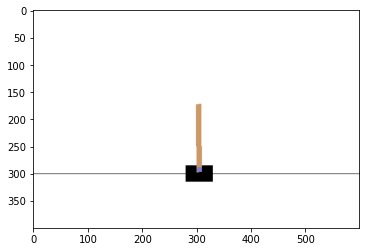

In [5]:
# Check if render indeed works by plotting initial state
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1")
env.reset()

def plot_initial(env):
  img = env.render(mode="rgb_array")
  np_img = np.array(img)

  print('Shape of image: ', np_img.shape)

  plt.imshow(np_img)
  plt.show()

plot_initial(env)

In [6]:
# DQN and double DQN for the cartpole environment (With option for duelling architecture)
# Can consider soft target update as well

# Import packages
import numpy as np
import gym

import time
import random
from collections import deque

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense

In [7]:
# Load CartPole-v1 environment with 4 states (cart position, cart velocity, pole angle, pole tip velocity) and 2 actions (left, right)
max_env_steps = 1000

env = gym.make("CartPole-v1")
env._max_episode_steps = max_env_steps

In [11]:
# Look at what the (state, action) is like in the environment
print("Action Space: ", env.action_space)
print("State space: ", env.observation_space)

action_space = env.action_space # Store encoding of action space
num_actions = env.action_space.n  # Number of actions

state_shape = env.observation_space.shape # Shape of state

Action Space:  Discrete(2)
State space:  Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [12]:
# Main and Target network architecture
def cartpole_agent(state_shape, num_actions, dueling_architecture):

  # A mapping from state to Q value of actions, Q(s, a|theta), theta are parameters of the net
  # Input: 
  # state_shape: Shape of the state input
  # num_actions: Number of actions
  # dueling_architecture: Flag for dueling architecture
  # Output: Q(s, a) for each action in action space

  learning_rate = 0.00025 # Learning rate

  # Number of hidden units in the two layers
  num_hidden = 64

  weight_init = tf.keras.initializers.HeUniform() # Weight intializer

  input_tensor = keras.Input(shape=state_shape) # Input tensor to the architecture

  main_stream = Dense(units=8*num_hidden, activation='relu', kernel_initializer=weight_init)(input_tensor) # First hidden layer
  main_stream = Dense(units=4*num_hidden, activation='relu', kernel_initializer=weight_init)(main_stream) # Second hidden layer
  main_stream = Dense(units=num_hidden, activation='relu', kernel_initializer=weight_init)(main_stream) # Second hidden layer

  if dueling_architecture:
    # Define Dueling architecture
    value_units = 12
    adv_units = 12

    # Value stream
    value_stream = Dense(units=value_units, activation='relu', kernel_initializer=weight_init)(main_stream)
    V = Dense(units=1, activation='linear', kernel_initializer=weight_init)(value_stream)

    # Advantage stream
    adv_stream = Dense(units=adv_units, activation='relu', kernel_initializer=weight_init)(main_stream)
    A = Dense(units=num_actions, activation='linear', kernel_initializer=weight_init)(adv_stream)

    # Aggregate the streams
    q_out = V + tf.subtract(A, tf.reduce_mean(A, axis=1, keepdims=True))
    out_tensor = q_out

  else:
    out_tensor = Dense(units=num_actions, activation='linear', kernel_initializer=weight_init)(main_stream) # Output layer

  model = keras.Model(inputs=input_tensor, outputs=out_tensor)

  # Use Huber loss, Adam optimizer, and report accuracies
  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=[tf.keras.metrics.MeanSquaredError()]) 
  
  return model

# Add batch dimension
def expand_state(cur_state):

  state = np.expand_dims(cur_state, axis=0)

  return state

def train_main_net(experience_replay, main_net, target_net, double_dqn):
  # Function that trains the main net using experiences 
  # Inputs:
  # experience_replay: Past experiences stored in the form [state, action, reward, next_state, done]
  # main_net: The main network
  # target_net: The target network
  # double dqn: Flag for Double DQN learning
  # Outputs:
  # Trained version of main_net (does not return it)

  alpha = 0.7 # learning rate of Q-learning
  gamma = 0.95 # Discount factor of Q-learning

  min_experience = 2000 # Minimum size of replay memory

  if len(experience_replay) < min_experience: # If there isn't enough experience, don't train
    return

  num_experiences = 32 # Number of experiences to train on

  random_experiences = random.sample(experience_replay, num_experiences) # Sample random experiences from memory
  cur_states = np.array([experience[0] for experience in random_experiences]) # Retrieve current state from those experiences
  next_states = np.array([experience[3] for experience in random_experiences]) # Retrieve next state from those experiences

  q_vals_cur = main_net.predict(cur_states) # Q values of current state returned from main net
  q_vals_next = target_net.predict(next_states) # Q values of next state returned from target net

  # Used for training main net
  states = [] # current state obtained from experience
  target_q_vals = [] # Q-values of current state calculated from target net (Using Bellman equation)

  # Go over all selected experiences to set the training data and labels
  for i, (state, action, reward, next_state, done) in enumerate(random_experiences):
    
    if done: # If episode terminated, the next q value is simply the reward

      max_q_next = reward 

    else: # Update q value using Bellman Optimality equation (obtained from target)

      if double_dqn: # if double DQN learning

        expand_next_state = expand_state(next_state) # Add batch dimension to next state
        sel_action_main = np.argmax(np.squeeze(main_net.predict(expand_next_state))) # Select action using main net

        q_val_target = q_vals_next[i] # Get Q values of next state from target net

        max_q_next = reward + gamma*q_val_target[sel_action_main] # Evaluate selected action using target net

      else:

        max_q_next = reward + gamma*np.max(q_vals_next[i]) # Calculate Q using Bellman optimality

    q_val_cur = q_vals_cur[i] # Current q value

    # Update the Q-value of current state for the experienced action using Q-learning
    if double_dqn:
      q_val_cur[action] = max_q_next
      
    else:
      q_val_cur[action] = max_q_next # (1-alpha)*q_val_cur[action] + alpha*max_q_next

    states.append(state) # Store current state for training
    target_q_vals.append(q_val_cur) # Q value of current state updated using target, used as the label
  
  # Standard notation for data and labels
  X = np.array(states)
  y = np.array(target_q_vals)

  main_net.fit(X, y, batch_size=num_experiences, shuffle=True, verbose=0) # Train the main net with the collected experiences

In [13]:
# Main function
double_dqn = False # flag for Double DQN learning (slows down a lot)
dueling_architecture = False # Flag for using dueling architecture

max_epsilon = 1 # We can't explore more than 100 % of the time
min_epsilon = 0.01 # At the minimum we explore 1 % of the time
decay = 0.01 # decay rate (exponential)

epsilon = max_epsilon # Start with the max value and decay exponentially with # of episodes

num_update_target = 100 # Number of steps before copying main network weights to target network
steps = 0 # Total number of steps taken (across episodes)

memory = 50000 # Max replay memory length
experience_replay = deque(maxlen=memory) # Deque for efficiency and for having a fixed memory

# Both main and target share the same architecture
main_net = cartpole_agent(state_shape, num_actions, dueling_architecture)
target_net = cartpole_agent(state_shape, num_actions, dueling_architecture) 
target_net.set_weights(main_net.get_weights()) # Initialize target weights with the weights of the main network

num_steps_main = 4 # Number of steps before training main

train_episodes = 5000 # Number of training episodes

all_rewards = [] # Keep a track of rewards obtained in each episodes
running_avg_rewards = [] # Running average over history length episodes
history_length = 100

for eps in range(train_episodes):

  cur_state = env.reset() # Current state

  episode_reward = 0 # reward obtained in current episode

  done = False # True when episode terminates

  while not done:

    u = np.random.uniform() # Sample from uniform distribution

    if u < epsilon: # We explore

      cur_action = action_space.sample()

    else: # We exploit

      expand_cur_state = expand_state(cur_state) # Add batch axis
      q_vals_cur = main_net.predict(expand_cur_state)  # Q value of current state as predicted by main net

      cur_action = np.argmax(np.squeeze(q_vals_cur)) # For the current state, select action that maximizes Q value

    next_state, reward, done, info = env.step(cur_action) # Take a step in the environment with the selected action
    experience_replay.append([cur_state, cur_action, reward, next_state, done]) # Add experience to memory

    # Update steps and reward of current episode
    steps += 1
    episode_reward += reward

    if steps % num_steps_main == 0 or done: # Train the main net

      train_main_net(experience_replay, main_net, target_net, double_dqn)

    if steps % num_update_target == 0: # Update weights of target net by copying weights from main net

      print('Copying weights from main to target')
      target_net.set_weights(main_net.get_weights())

    cur_state = next_state # Transition to new state
    
  epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay*eps) # Decay epsilon

  # Print some statistics to check if there's learning
  print('Epsiode {} statistics: '.format(eps+1))
  print('Reward obtained: ', episode_reward)

  if len(all_rewards) > history_length:
    del all_rewards[:1]

  all_rewards.append(episode_reward)
  running_avg_rewards.append(np.mean(all_rewards))



Epsiode 1 statistics: 
Reward obtained:  49.0
Epsiode 2 statistics: 
Reward obtained:  20.0
Copying weights from main to target
Epsiode 3 statistics: 
Reward obtained:  87.0
Copying weights from main to target
Epsiode 4 statistics: 
Reward obtained:  44.0
Epsiode 5 statistics: 
Reward obtained:  20.0
Epsiode 6 statistics: 
Reward obtained:  17.0
Epsiode 7 statistics: 
Reward obtained:  10.0
Epsiode 8 statistics: 
Reward obtained:  25.0
Epsiode 9 statistics: 
Reward obtained:  23.0
Copying weights from main to target
Epsiode 10 statistics: 
Reward obtained:  19.0
Epsiode 11 statistics: 
Reward obtained:  15.0
Epsiode 12 statistics: 
Reward obtained:  16.0
Epsiode 13 statistics: 
Reward obtained:  16.0
Epsiode 14 statistics: 
Reward obtained:  29.0
Copying weights from main to target
Epsiode 15 statistics: 
Reward obtained:  10.0
Epsiode 16 statistics: 
Reward obtained:  22.0
Epsiode 17 statistics: 
Reward obtained:  17.0
Epsiode 18 statistics: 
Reward obtained:  19.0
Epsiode 19 statisti

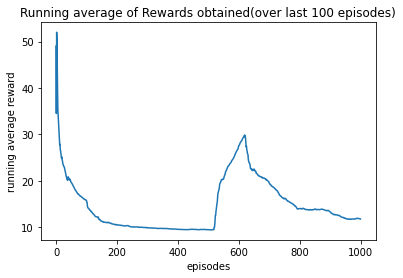

In [14]:
import matplotlib.pyplot as plt

plt.plot(running_avg_rewards)
plt.title('Running average of Rewards obtained(over last {} episodes)'.format(history_length))
plt.xlabel('episodes')
plt.ylabel('running average reward')
plt.show()

In [15]:
def make_video(frames, episode):

  size = frames[0].shape # Size of each image in frame
  fps = 30
  out = cv2.VideoWriter('trained_agent_eval_{}.mp4'.format(episode), cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0])) # Assumes RGB, need to only pass (width, height)

  for frame in frames:
      data = frame[:, :, ::-1] # assumes BGR format, so reverse channels
      out.write(data)

  out.release()

avg_eval_reward = 0
eval_episodes = 10

for episode in range(eval_episodes):

  cur_state = env.reset()
  done = False

  eval_episode_reward = 0

  frames = []

  while not done:

    epsilon = 0.0

    u = np.random.uniform() # Sample from uniform distribution

    if u < epsilon: # We explore

      cur_action = action_space.sample()

    else: # We exploit

      expand_cur_state = expand_state(cur_state) # Add batch axis
      q_vals_cur = main_net.predict(expand_cur_state)  # Q value of current state as predicted by main net
      cur_action = np.argmax(np.squeeze(q_vals_cur)) # For the current state, select action that maximizes Q value

    next_state, reward, done, info = env.step(cur_action) # Take a step in the environment with the selected action

    eval_episode_reward += reward

    cur_img_state = env.render('rgb_array')
    frames.append(cur_img_state)

    cur_state = next_state

  avg_eval_reward += eval_episode_reward

  make_video(frames, episode+1)
  print('Reward obtained in evaluation {}: {}'.format(episode+1, eval_episode_reward))

avg_eval_reward /= eval_episodes
print('Average evaluation reward over {} episodes is: {}'.format(eval_episodes, avg_eval_reward))

Reward obtained in evaluation 1: 10.0
Reward obtained in evaluation 2: 11.0
Reward obtained in evaluation 3: 10.0
Reward obtained in evaluation 4: 9.0
Reward obtained in evaluation 5: 9.0
Reward obtained in evaluation 6: 10.0
Reward obtained in evaluation 7: 10.0
Reward obtained in evaluation 8: 10.0
Reward obtained in evaluation 9: 9.0
Reward obtained in evaluation 10: 9.0
Average evaluation reward over 10 episodes is: 9.7
